In [2]:
#%pip install comet-ml

In [3]:
from google.colab import userdata
from comet_ml import Experiment
experiment = Experiment(api_key="COMET_API_KEY")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET ERROR: The given API key 'COMET_API_KEY' is invalid on 'www.comet.com', please check it against the dashboard. Your experiment will not be logged 
For more details, please refer to: https://www.comet.com/docs/v2/api-and-sdk/python-sdk/warnings-errors/


In [13]:
#%pip install torch torchvision torchaudio
#%pip install einops
#%pip install datasets
#%pip install transformers
#%pip install tqdm
#%pip install kneed
#%pip install pytorch_lightning
#%pip install torchinfo
#%pip install umap-learn

In [6]:
#Biblioteki do przetwarzania danych i modeli
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.classification import MulticlassAccuracy
import h5py
from einops import rearrange
import pandas as pd

#Biblioteki do klasteryzacji
from sklearn.cluster import KMeans
#from kneed import KneeLocator

#Biblioteki do redukcji wymiarowości
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#Biblioteki do wizualizacji
import matplotlib.pyplot as plt

#Biblioteki pomocnicze
import time
from tqdm import tqdm


# Importy
import os



In [7]:
#Wybór urządzenia GPU (CUDA), jeśli dostępne
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Używane urządzenie:", device)

Używane urządzenie: cuda


In [8]:
from google.colab import files

uploaded_files = files.upload()

Saving kaggle.json to kaggle.json


In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [10]:
!kaggle datasets download -d milche/wikiart-clean

Dataset URL: https://www.kaggle.com/datasets/milche/wikiart-clean
License(s): unknown
100% 9.82G/9.83G [02:22<00:00, 92.7MB/s]
100% 9.83G/9.83G [02:22<00:00, 74.2MB/s]


In [11]:
!mkdir wikiart-clean
!unzip -q wikiart-clean.zip -d wikiart-clean

In [14]:
import os

for dirname, _, filenames in os.walk('/content/wikiart-clean'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/wikiart-clean/test.h5
/content/wikiart-clean/test.csv
/content/wikiart-clean/train.csv
/content/wikiart-clean/valid.h5
/content/wikiart-clean/valid.csv
/content/wikiart-clean/train.h5


In [15]:
class WikiArtDataset(Dataset):
    def __init__(self, annotations_file: str, h5_path: str, label_idx=2, transform=None, target_transform=None):
        """
        A dataset for WikiArt data integrated with HDF5 image reading.

        Parameters:
            annotations_file (str): Path to the CSV file containing labels.
            h5_path (str): Path to the HDF5 file containing images.
            label_idx (int, optional): Index of the label column in the CSV file. Defaults to 2 (style).
            transform (callable, optional): A function to transform the images.
            target_transform (callable, optional): A function to transform the labels.

        Initializes the dataset to load images and labels from the CSV and HDF5 files.
        """
        self.img_labels = pd.read_csv(annotations_file)
        self.h5_path = h5_path
        self.label_idx = label_idx
        self.transform = transform
        self.target_transform = target_transform

        self.label_map = {label: idx for idx, label in enumerate(self.img_labels.iloc[:, self.label_idx].unique())}

        with h5py.File(self.h5_path, 'r') as h5f:
            self.length = len(h5f['image'])

    def __len__(self):
        """
        Returns the total number of elements in the dataset.

        Returns:
            int: The number of images in the dataset.
        """
        return self.length

    def _open_hdf5(self):
        """
        Opens the HDF5 file if it hasn't been opened yet.
        """
        if not hasattr(self, '_hf') or self._hf is None:
            self._hf = h5py.File(self.h5_path, 'r')

    def __getitem__(self, idx):
        """
        Retrieves an image and its corresponding label based on the given index.

        Parameters:
            idx (int): The index of the element to retrieve.

        Returns:
            tuple: A tuple containing the image (torch.Tensor) and the label (int).
        """
        self._open_hdf5()

        image = self._hf['image'][idx]
        image = torch.from_numpy(image)

        label = self.img_labels.iloc[idx, self.label_idx]
        label = self.label_map[label]

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [16]:
class UNet(nn.Module):
    def __init__(self, reduce_dim=128):
        super(UNet, self).__init__()

        # Definicje enkoderów
        self.encoder1 = self._block(3, 16)
        self.encoder2 = self._block(16, 32)
        self.encoder3 = self._block(32, 64)
        self.encoder4 = self._block(64, 128)

        # Bottleneck
        self.bottleneck = self._block(128, 256)

        # Redukcja wymiarowości dla bottleneck
        self.feature_reducer = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global Average Pooling
            nn.Flatten(),  # Spłaszczenie
            nn.Linear(256, reduce_dim)  # Redukcja wymiaru
        )

        # Definicje dekoderów
        self.decoder4 = self._up_block(256, 128)
        self.decoder3 = self._up_block(128, 64)
        self.decoder2 = self._up_block(64, 32)
        self.decoder1 = self._up_block(32, 16)

        # Finalna konwolucja
        self.final_conv = nn.Conv2d(16, 3, kernel_size=1)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
        )

    def _up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        # Enkodowanie
        e1 = self.encoder1(x)
        e2 = self.encoder2(nn.functional.max_pool2d(e1, kernel_size=2))
        e3 = self.encoder3(nn.functional.max_pool2d(e2, kernel_size=2))
        e4 = self.encoder4(nn.functional.max_pool2d(e3, kernel_size=2))

        # Bottleneck
        b = self.bottleneck(nn.functional.max_pool2d(e4, kernel_size=2))

        # Dekodowanie
        d4 = self.decoder4(b)
        d3 = self.decoder3(d4 + e4)
        d2 = self.decoder2(d3 + e3)
        d1 = self.decoder1(d2 + e2)

        # Wyjście
        out = self.final_conv(d1 + e1)
        return out

    def extract_features(self, x, reduce=False):
        """
        Ekstrakcja cech z warstwy bottleneck.

        :param x: Dane wejściowe.
        :param reduce: Czy redukować wymiarowość cech. Domyślnie False.
        :return: Tensor cech (surowy lub po redukcji wymiarów).
        """
        e1 = self.encoder1(x)
        e2 = self.encoder2(nn.functional.max_pool2d(e1, kernel_size=2))
        e3 = self.encoder3(nn.functional.max_pool2d(e2, kernel_size=2))
        e4 = self.encoder4(nn.functional.max_pool2d(e3, kernel_size=2))
        b = self.bottleneck(nn.functional.max_pool2d(e4, kernel_size=2))

        if reduce:
            return self.feature_reducer(b)
        else:
            return b


In [17]:
class UNetLightning(pl.LightningModule):
    def __init__(self, learning_rate=1e-3, reduce_dim=128):
        super(UNetLightning, self).__init__()
        self.model = UNet(reduce_dim=reduce_dim)
        self.criterion = nn.SmoothL1Loss()  # Funkcja straty
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, _ = batch
        reconstructed = self(x)
        loss = self.criterion(reconstructed, x)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        reconstructed = self(x)
        loss = self.criterion(reconstructed, x)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, _ = batch
        reconstructed = self(x)
        loss = self.criterion(reconstructed, x)
        self.log('test_loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def extract_features(self, x):
        """
        Wywołanie funkcji extract_features z modelu UNet.
        """
        return self.model.extract_features(x)

    def summary(self, input_size=(3, 224, 224)):
        """
        Wyświetla szczegóły modelu i warstw, korzystając z torchinfo.

        :param input_size: Rozmiar danych wejściowych (domyślnie: (3, 224, 224))
        """
        return summary(self.model, input_size=(1, *input_size), col_names=["input_size", "output_size", "num_params", "kernel_size"], depth=3)


In [18]:
# Tworzenie modelu
model = UNetLightning()

# Wyświetlanie podsumowania
print(model.summary())

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
UNet                                     [1, 3, 224, 224]          [1, 3, 224, 224]          32,896                    --
├─Sequential: 1-1                        [1, 3, 224, 224]          [1, 16, 224, 224]         --                        --
│    └─Conv2d: 2-1                       [1, 3, 224, 224]          [1, 16, 224, 224]         448                       [3, 3]
│    └─ReLU: 2-2                         [1, 16, 224, 224]         [1, 16, 224, 224]         --                        --
│    └─BatchNorm2d: 2-3                  [1, 16, 224, 224]         [1, 16, 224, 224]         32                        --
│    └─Conv2d: 2-4                       [1, 16, 224, 224]         [1, 16, 224, 224]         2,320                     [3, 3]
│    └─ReLU: 2-5                         [1, 16, 224, 224]         [1, 16, 224, 224]         --                        --
│    └

In [19]:
# Podłączenie Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Ścieżka do zapisu modeli
save_dir = '/content/drive/MyDrive/models'
os.makedirs(save_dir, exist_ok=True)

Mounted at /content/drive


In [20]:
# Transformacje dla danych
transform = transforms.Compose([
    #transforms.Resize((224, 224)),  # Zmiana rozmiaru na 224x224
    #transforms.ToTensor(),  # Konwertuje obrazy na torch.Tensor
    transforms.ConvertImageDtype(torch.float),  # Konwertuje dane na float32
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizacja
])

train_dataset = WikiArtDataset(
    annotations_file='/content/wikiart-clean/train.csv',
    h5_path='/content/wikiart-clean/train.h5',
    transform=transform
)

valid_dataset = WikiArtDataset(
    annotations_file='/content/wikiart-clean/valid.csv',
    h5_path='/content/wikiart-clean/valid.h5',
    transform=transform
)

test_dataset = WikiArtDataset(
    annotations_file='/content/wikiart-clean/test.csv',
    h5_path='/content/wikiart-clean/test.h5',
    transform=transform
)

In [21]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
valid_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [22]:
# Callbacks do zapisu najlepszych modeli
checkpoint_callback = ModelCheckpoint(
    dirpath=save_dir,
    filename='unet-{epoch:02d}-{val_loss:.4f}',
    save_top_k=1,
    mode='min',
    monitor='val_loss'
)

# Trenowanie
trainer = pl.Trainer(
    max_epochs=22,
    callbacks=[checkpoint_callback],
    accelerator='gpu',  # Wykorzystanie GPU
    devices=1
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_dataloader, valid_dataloader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/models exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type         | Params | Mode 
---------------------------------------------------
0 | model     | UNet         | 1.4 M  | train
1 | criterion | SmoothL1Loss | 0      | train
---------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.554     Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=22` reached.


In [23]:
#Zmodyfikowanie dataloader'ów (mniejszy batch size)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=2)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [24]:
# Ścieżka do najlepszego modelu (z checkpoint_callback lub podajemy ręcznie)
#best_model_path = checkpoint_callback.best_model_path
best_model_path = '/content/drive/MyDrive/models/models.ckpt'
print(f"Best model saved at: {best_model_path}")

# Załadowanie modelu z checkpointu
model = UNetLightning.load_from_checkpoint(
    best_model_path)
# Trenowanie
trainer = pl.Trainer(
    max_epochs=1,
    callbacks=[checkpoint_callback],
    accelerator='gpu',  # Wykorzystanie GPU
    devices=1
)

# Przejście modelu w tryb ewaluacji
model.eval()

Best model saved at: /content/drive/MyDrive/models/models.ckpt


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


UNetLightning(
  (model): UNet(
    (encoder1): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (encoder2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (encoder3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    

In [ ]:
trainer.test(model, test_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │  3.0310686270240694e-05   │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 3.0310686270240694e-05}]

In [25]:
import numpy as np
import torch
from sklearn.decomposition import PCA
from tqdm import tqdm

# Sprawdzenie, czy GPU jest dostępne
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Przeniesienie modelu na GPU
model = model.to(device)
model.eval()

# Konfiguracja PCA
n_components = 32  # Liczba wymiarów po redukcji
pca = PCA(n_components=n_components)

# Lista do przechowywania cech
features = []

# Flaga wskazująca, czy PCA zostało dopasowane
is_pca_fitted = False

# Przetwarzanie danych
with torch.no_grad():
    for batch in tqdm(train_dataloader, desc="Processing batches"):
        images, _ = batch  # Pobranie obrazów z batcha
        images = images.to(device)  # Przeniesienie obrazów na GPU

        # Wyciąganie cech z modelu
        extracted_features = model.extract_features(images).cpu().numpy()

        # Spłaszczenie wymiarów przestrzennych
        extracted_features = extracted_features.reshape(extracted_features.shape[0], -1)

        # Dopasowanie PCA na pierwszej partii danych
        if not is_pca_fitted:
            pca.fit(extracted_features)
            is_pca_fitted = True

        # Redukcja wymiarowości
        reduced_features = pca.transform(extracted_features)

        # Dodanie zredukowanych cech do listy
        features.append(reduced_features)

# Łączenie wszystkich partii w jedną tablicę numpy
features = np.concatenate(features, axis=0)

print(f"Shape of reduced features: {features.shape}")

Processing batches: 100%|██████████| 2196/2196 [03:27<00:00, 10.59it/s]

Shape of reduced features: (70268, 32)


Testing number of clusters: 100%|██████████| 8/8 [06:52<00:00, 51.61s/it]


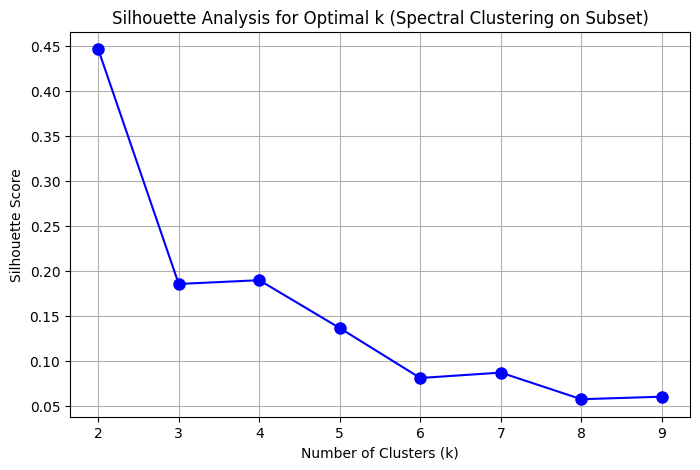

In [ ]:
import numpy as np
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# Redukcja danych do 20% oryginalnego zbioru treningowego
sample_fraction = 0.2  # Procent próbek
n_samples = int(features.shape[0] * sample_fraction)  # Liczba próbek po redukcji
subset_indices = np.random.choice(features.shape[0], n_samples, replace=False)  # Losowe indeksy
subset_features = features[subset_indices]  # Podzbiór danych

# Zakres liczby klastrów do przetestowania
k_values = range(2, 10)  # Spectral Clustering wymaga co najmniej 2 klastrów
silhouette_scores = []

# Przetwarzanie Spectral Clustering dla różnych liczby klastrów
for k in tqdm(k_values, desc="Testing number of clusters"):
    spectral = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42)
    labels = spectral.fit_predict(subset_features)  # Klasteryzacja na podzbiorze danych

    # Obliczanie wyniku silhouette (dla oceny jakości klasteryzacji)
    score = silhouette_score(subset_features, labels)
    silhouette_scores.append(score)

# Wizualizacja metody silhouette
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, 'bo-', markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k (Spectral Clustering on Subset)')
plt.grid()
plt.show()

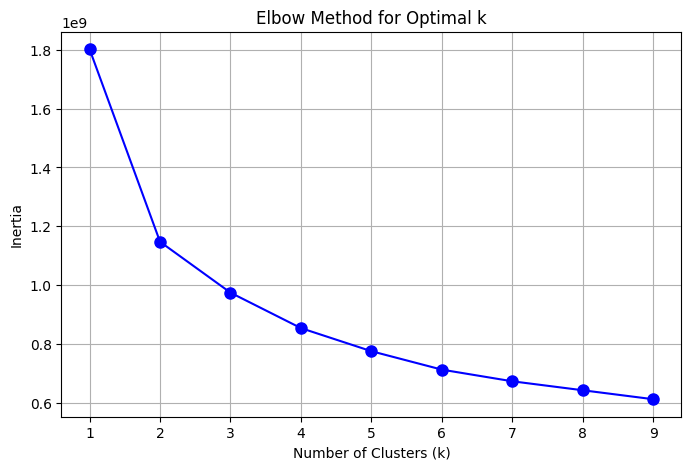

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Zakres liczby klastrów do przetestowania
k_values = range(1, 10)
inertia = []

# Obliczanie inercji dla różnych liczby klastrów
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)  # features to dane z encodera
    inertia.append(kmeans.inertia_)

# Wizualizacja metody łokcia
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, 'bo-', markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid()
plt.show()

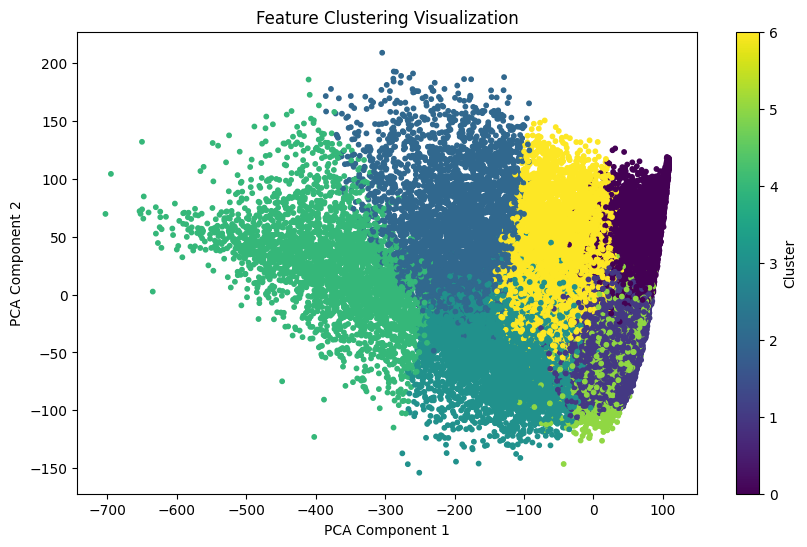

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Liczba klastrów
clusters = 7

# Klasteryzacja
kmeans = KMeans(n_clusters=clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features)

# Redukcja wymiarów z PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

# Wizualizacja klastrów
plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels, cmap='viridis', s=10)
plt.colorbar(label='Cluster')
plt.title('Feature Clustering Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


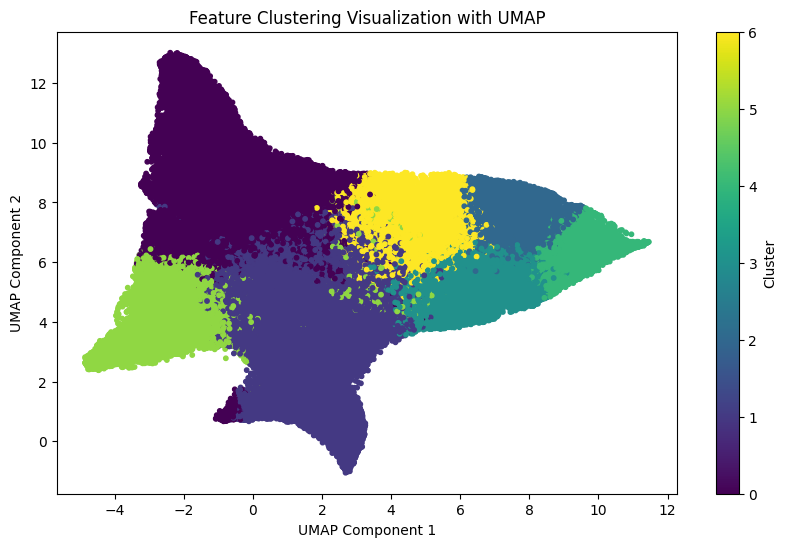

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import umap
import numpy as np

# Liczba klastrów
clusters = 7

# Klasteryzacja
kmeans = KMeans(n_clusters=clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features)

# Redukcja wymiarów z UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
reduced_features_umap = umap_reducer.fit_transform(features)

# Wizualizacja klastrów z UMAP
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    reduced_features_umap[:, 0],
    reduced_features_umap[:, 1],
    c=cluster_labels,
    cmap='viridis',
    s=10
)
plt.colorbar(scatter, label='Cluster')
plt.title('Feature Clustering Visualization with UMAP')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

In [ ]:
#Ekstrakcja cech i klasteryzacja poszczególnych podzbiorów

In [28]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from sklearn.decomposition import PCA

# Model w trybie ewaluacji
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Konfiguracja PCA
n_components = 32
pca = PCA(n_components=n_components)

# Listy do przechowywania danych
features_list = []
indices_list = []  # Lista indeksów
labels_list = []   # Lista etykiet

# Flaga wskazująca, czy PCA zostało dopasowane
is_pca_fitted = False

with torch.no_grad():
    for idx, batch in enumerate(tqdm(train_dataloader, desc="Processing batches")):
        images, labels = batch  # Pobieranie obrazów i etykiet
        images = images.to(device)

        # Wyciąganie cech
        extracted_features = model.extract_features(images).cpu().numpy()

        # Spłaszczenie wymiarów przestrzennych
        extracted_features = extracted_features.reshape(extracted_features.shape[0], -1)

        # Dopasowanie PCA na pierwszej partii danych
        if not is_pca_fitted:
            pca.fit(extracted_features)
            is_pca_fitted = True

        # Redukcja wymiarowości
        reduced_features = pca.transform(extracted_features)

        # Dodawanie cech, indeksów i etykiet do list
        features_list.extend(reduced_features)
        indices_list.extend(range(idx * len(images), idx * len(images) + len(images)))
        labels_list.extend(labels.cpu().numpy())

# Zapis do pliku .npz (cechy) i CSV (indeksy oraz etykiety)
features_array = np.array(features_list)
save_features_path = '/content/drive/MyDrive/extracted_features.npz'
save_indices_labels_path = '/content/drive/MyDrive/sample_indices_labels.csv'

np.savez_compressed(save_features_path, features=features_array)
pd.DataFrame({
    'index': indices_list,
    'label': labels_list
}).to_csv(save_indices_labels_path, index=False)

print(f"Cechy zapisane w: {save_features_path}")
print(f"Indeksy i etykiety zapisane w: {save_indices_labels_path}")

Processing batches: 100%|██████████| 2196/2196 [04:15<00:00,  8.61it/s]


Cechy zapisane w: /content/drive/MyDrive/extracted_features.npz
Indeksy i etykiety zapisane w: /content/drive/MyDrive/sample_indices_labels.csv


In [29]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

# Wczytanie cech i indeksów z etykietami
features_file = '/content/drive/MyDrive/extracted_features.npz'
indices_labels_file = '/content/drive/MyDrive/sample_indices_labels.csv'

data = np.load(features_file)
features = data['features']
indices_labels = pd.read_csv(indices_labels_file)

# Klasteryzacja
clusters = 7
kmeans = KMeans(n_clusters=clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features)

# Dodanie klastrów do DataFrame
indices_labels['cluster_label'] = cluster_labels

# Zapis wyników do pliku CSV
save_results_path = '/content/drive/MyDrive/clustered_train.csv'
indices_labels.to_csv(save_results_path, index=False)

print(f"Wyniki klasteryzacji zapisane w: {save_results_path}")

Wyniki klasteryzacji zapisane w: /content/drive/MyDrive/clustered_train.csv


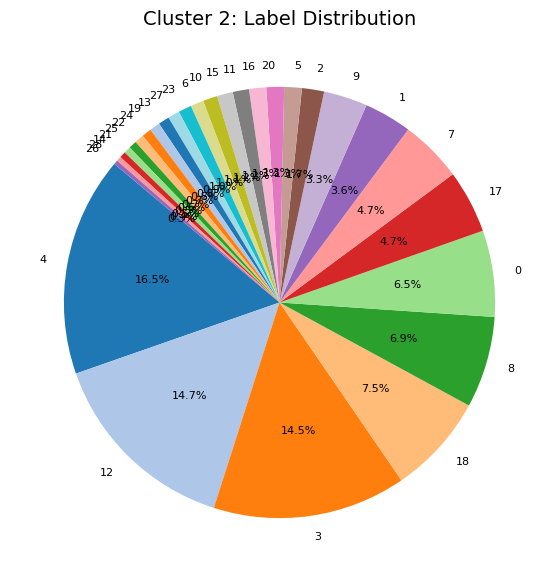

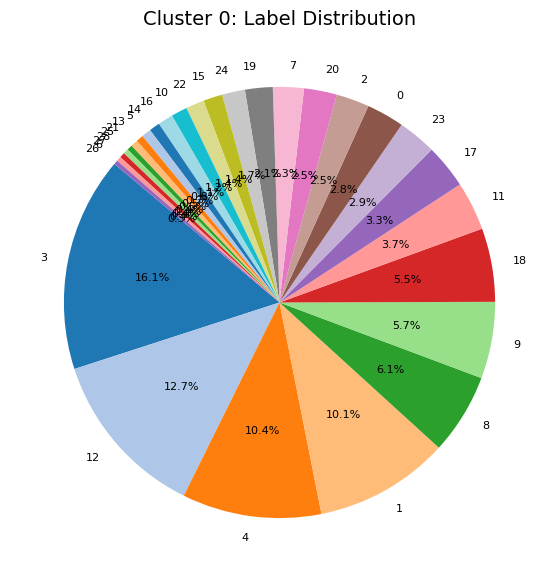

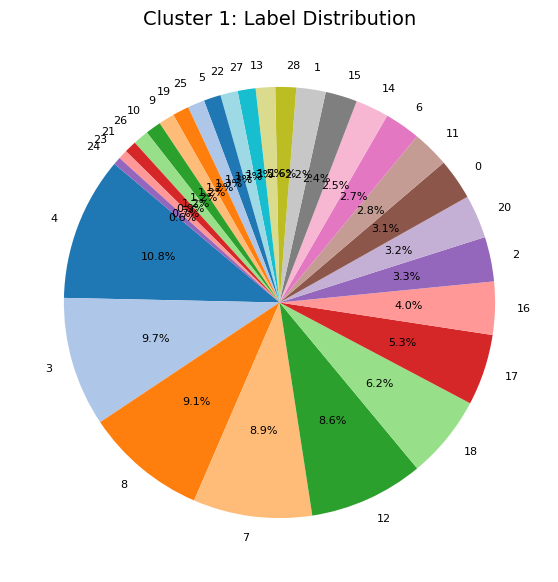

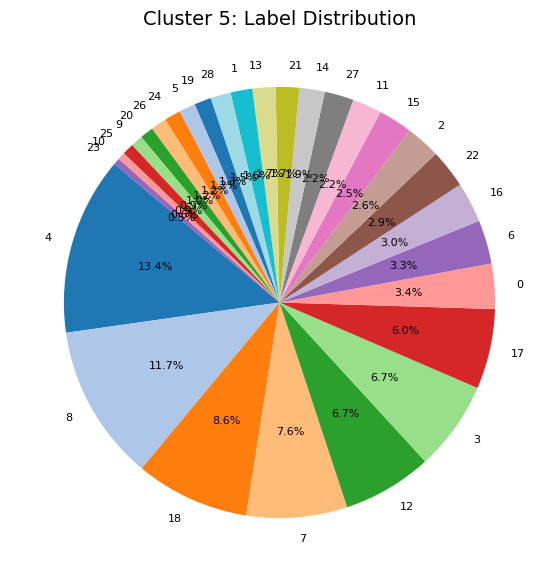

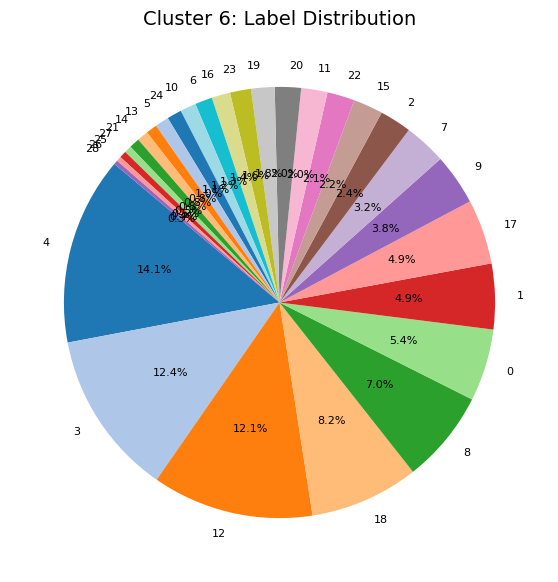

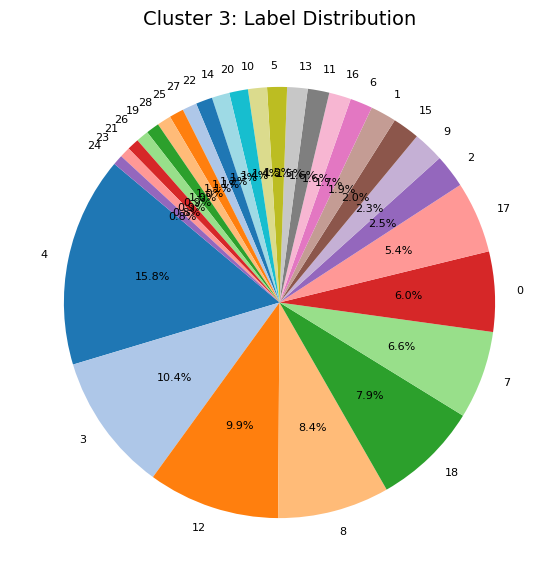

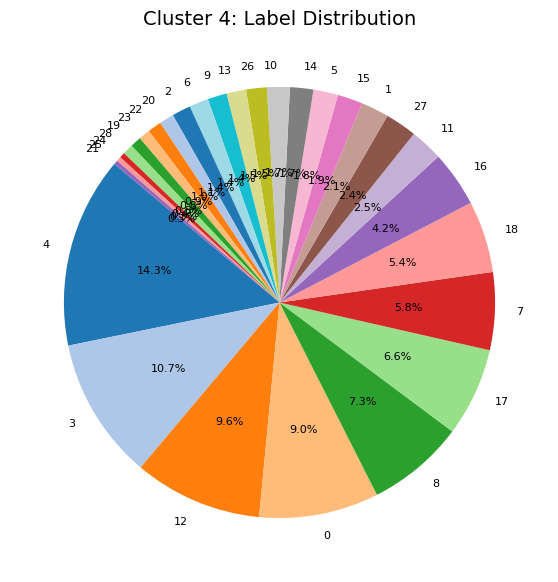

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Ścieżka do pliku wynikowego
clustered_file_path = '/content/drive/MyDrive/clustered_train.csv'

# Wczytanie danych
data = pd.read_csv(clustered_file_path)

# Unikalne klastry
clusters = data['cluster_label'].unique()

# Tworzenie wykresów kołowych dla każdego klastra
for cluster in clusters:
    # Filtrowanie danych dla aktualnego klastra
    cluster_data = data[data['cluster_label'] == cluster]

    # Liczenie wystąpień każdej etykiety w klastrze
    label_counts = cluster_data['label'].value_counts()

    # Przygotowanie danych do wykresu
    sizes = label_counts.values
    labels = label_counts.index

    # Tworzenie wykresu kołowego
    fig, ax = plt.subplots(figsize=(7, 7))
    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=labels,  # Etykiety wewnątrz
        autopct='%1.1f%%',  # Procenty na zewnątrz
        startangle=140,
        textprops={'color': "black"},  # Ustawienie koloru tekstu
        colors=plt.cm.tab20.colors[:len(label_counts)]
    )

    # Dostosowanie wyglądu procentów (na zewnątrz)
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontsize(8)
        autotext.set_fontweight('light')

    # Przesunięcie etykiet wewnątrz wykresu
    for text in texts:
        text.set_fontsize(8)
        text.set_fontweight('light')

    # Tytuł wykresu
    plt.title(f'Cluster {cluster}: Label Distribution', fontsize=14)

    # Wyświetlenie wykresu
    plt.show()


Wizualizacji różnych ilości klastrów

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


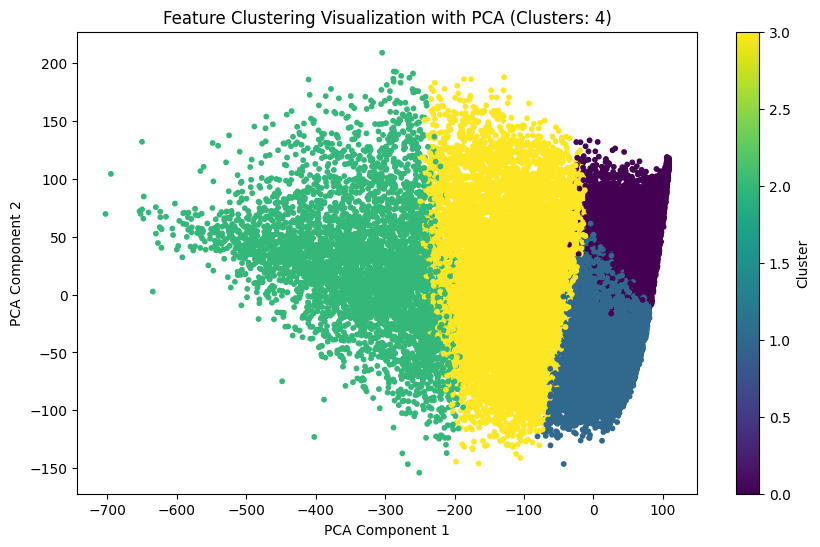

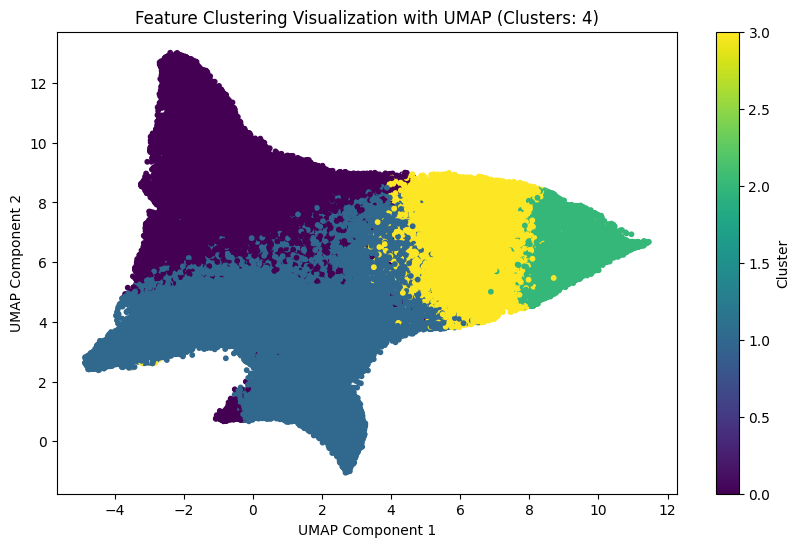

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


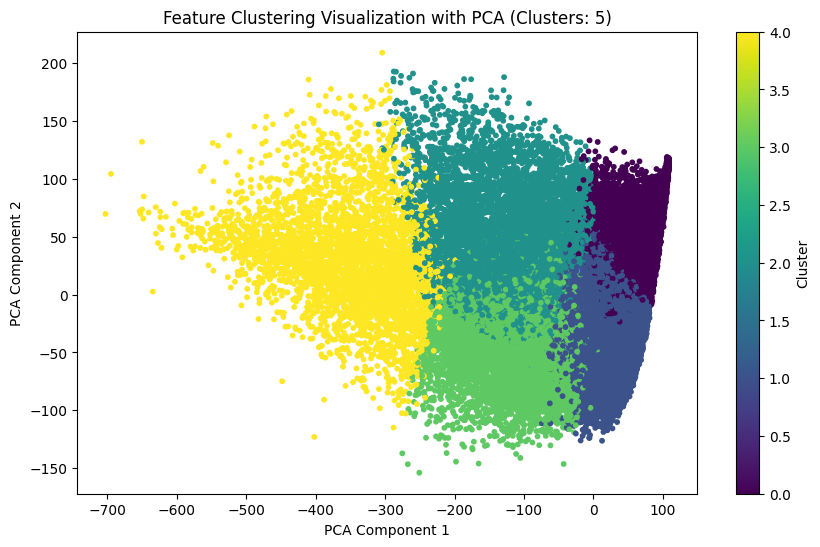

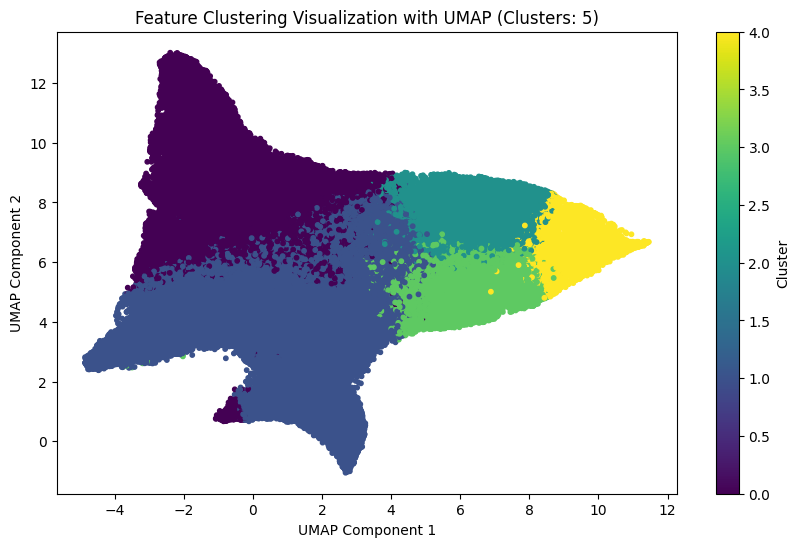

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


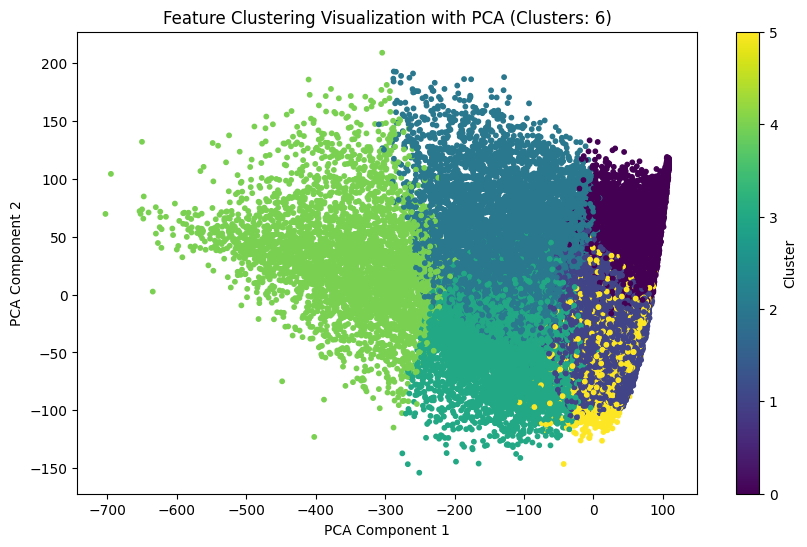

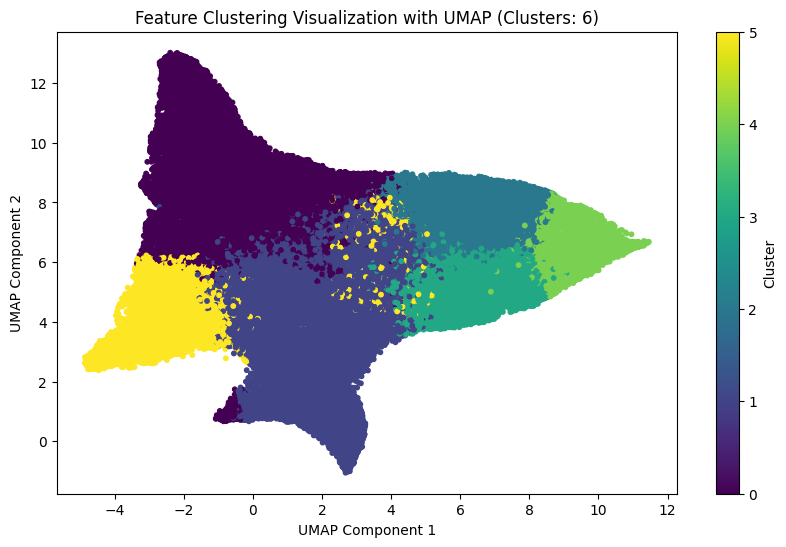

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


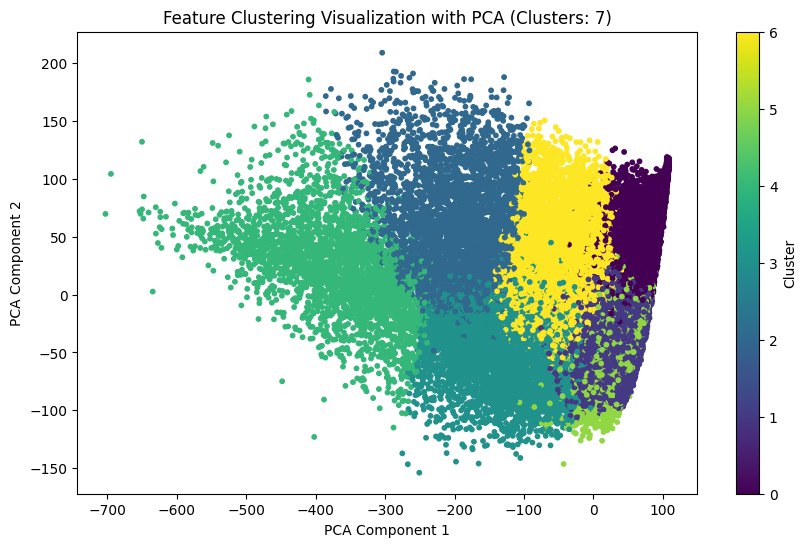

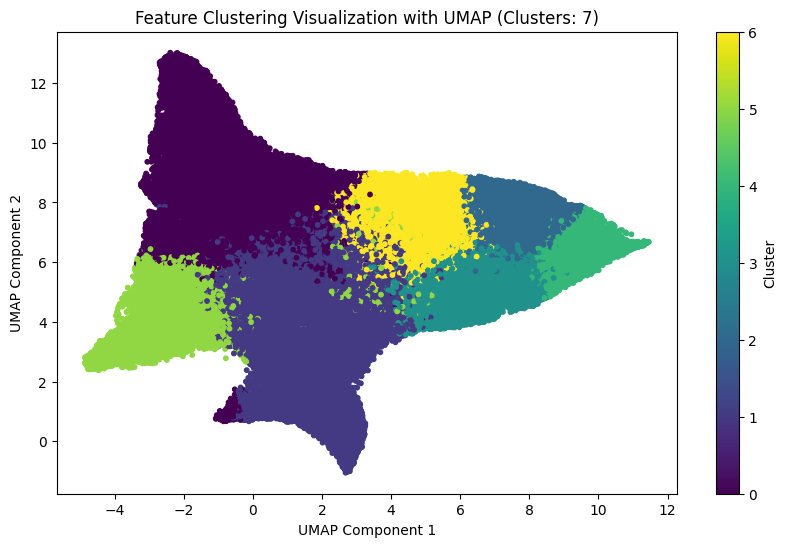

In [26]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap
import matplotlib.pyplot as plt

def generate_cluster_plots(features, cluster_counts=[4, 5, 6, 7]):
    """
    Generuje wykresy wizualizujące klastrowanie z redukcją wymiarów PCA i UMAP.

    Parametry:
    - features: ndarray, dane wejściowe do klasteryzacji
    - cluster_counts: lista, liczby klastrów do przetestowania

    Zwraca:
    - Brak (wykresy są wyświetlane)
    """
    for clusters in cluster_counts:
        # Klasteryzacja
        kmeans = KMeans(n_clusters=clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(features)

        # PCA - redukcja wymiarów
        pca = PCA(n_components=2)
        reduced_features_pca = pca.fit_transform(features)

        # UMAP - redukcja wymiarów
        umap_reducer = umap.UMAP(n_components=2, random_state=42)
        reduced_features_umap = umap_reducer.fit_transform(features)

        # Wykres PCA
        plt.figure(figsize=(10, 6))
        plt.scatter(
            reduced_features_pca[:, 0],
            reduced_features_pca[:, 1],
            c=cluster_labels,
            cmap='viridis',
            s=10
        )
        plt.colorbar(label='Cluster')
        plt.title(f'Feature Clustering Visualization with PCA (Clusters: {clusters})')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.show()

        # Wykres UMAP
        plt.figure(figsize=(10, 6))
        plt.scatter(
            reduced_features_umap[:, 0],
            reduced_features_umap[:, 1],
            c=cluster_labels,
            cmap='viridis',
            s=10
        )
        plt.colorbar(label='Cluster')
        plt.title(f'Feature Clustering Visualization with UMAP (Clusters: {clusters})')
        plt.xlabel('UMAP Component 1')
        plt.ylabel('UMAP Component 2')
        plt.show()

# Przykład użycia:
# Zakładając, że `features` to dane wejściowe jako ndarray
generate_cluster_plots(features, cluster_counts=[4, 5, 6, 7])

Przypisanie wszystkich obrazów do klastrów

In [ ]:
from google.colab import files

uploaded_files = files.upload()

Saving kaggle.json to kaggle (3).json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list --user milche

No datasets found


In [ ]:
!kaggle datasets download -d milche/wikiart-clean-without-split


Dataset URL: https://www.kaggle.com/datasets/milche/wikiart-clean-without-split
License(s): unknown
... resuming from 766509056 bytes (9788107502 bytes left) ...
100% 9.83G/9.83G [07:31<00:00, 23.5MB/s]
100% 9.83G/9.83G [07:31<00:00, 21.7MB/s]


In [ ]:
!mkdir wikiart-clean-without-split
!unzip -q wikiart-clean-without-split.zip -d wikiart-clean-without-split

mkdir: cannot create directory ‘wikiart-clean-without-split’: File exists


In [ ]:
import os

for dirname, _, filenames in os.walk('/content/wikiart-clean-without-split'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/wikiart-clean-without-split/dataset.h5
/content/wikiart-clean-without-split/annotations.csv


In [ ]:
# Transformacje dla danych
transform = transforms.Compose([
    #transforms.Resize((224, 224)),  # Zmiana rozmiaru na 224x224
    #transforms.ToTensor(),  # Konwertuje obrazy na torch.Tensor
    transforms.ConvertImageDtype(torch.float),  # Konwertuje dane na float32
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizacja
])

dataset = WikiArtDataset(
    annotations_file='/content/wikiart-clean-without-split/annotations.csv',
    h5_path='/content/wikiart-clean-without-split/dataset.h5',
    transform=transform
)

In [ ]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from sklearn.decomposition import PCA

# Model w trybie ewaluacji
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Konfiguracja PCA
n_components = 32
pca = PCA(n_components=n_components)

# Listy do przechowywania danych
features_list = []
indices_list = []  # Lista indeksów
labels_list = []   # Lista etykiet

# Flaga wskazująca, czy PCA zostało dopasowane
is_pca_fitted = False

with torch.no_grad():
    for idx, batch in enumerate(tqdm(dataloader, desc="Processing batches")):
        images, labels = batch  # Pobieranie obrazów i etykiet
        images = images.to(device)

        # Wyciąganie cech
        extracted_features = model.extract_features(images).cpu().numpy()

        # Spłaszczenie wymiarów przestrzennych
        extracted_features = extracted_features.reshape(extracted_features.shape[0], -1)

        # Dopasowanie PCA na pierwszej partii danych
        if not is_pca_fitted:
            pca.fit(extracted_features)
            is_pca_fitted = True

        # Redukcja wymiarowości
        reduced_features = pca.transform(extracted_features)

        # Dodawanie cech, indeksów i etykiet do list
        features_list.extend(reduced_features)
        indices_list.extend(range(idx * len(images), idx * len(images) + len(images)))
        labels_list.extend(labels.cpu().numpy())

# Zapis do pliku .npz (cechy) i CSV (indeksy oraz etykiety)
features_array = np.array(features_list)
save_features_path = '/content/drive/MyDrive/extracted_features.npz'
save_indices_labels_path = '/content/drive/MyDrive/sample_indices_labels.csv'

np.savez_compressed(save_features_path, features=features_array)
pd.DataFrame({
    'index': indices_list,
    'label': labels_list
}).to_csv(save_indices_labels_path, index=False)

print(f"Cechy zapisane w: {save_features_path}")
print(f"Indeksy i etykiety zapisane w: {save_indices_labels_path}")

Processing batches: 100%|██████████| 2745/2745 [04:04<00:00, 11.22it/s]


Cechy zapisane w: /content/drive/MyDrive/extracted_features.npz
Indeksy i etykiety zapisane w: /content/drive/MyDrive/sample_indices_labels.csv


In [ ]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

# Wczytanie cech i indeksów z etykietami
features_file = '/content/drive/MyDrive/extracted_features.npz'
indices_labels_file = '/content/drive/MyDrive/sample_indices_labels.csv'

data = np.load(features_file)
features = data['features']
indices_labels = pd.read_csv(indices_labels_file)

# Klasteryzacja
clusters = 7
kmeans = KMeans(n_clusters=clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features)

# Dodanie klastrów do DataFrame
indices_labels['cluster_label'] = cluster_labels

# Zapis wyników do pliku CSV
save_results_path = '/content/drive/MyDrive/clustered_full.csv'
indices_labels.to_csv(save_results_path, index=False)

print(f"Wyniki klasteryzacji zapisane w: {save_results_path}")

Wyniki klasteryzacji zapisane w: /content/drive/MyDrive/clustered_full.csv
